# Sarmalayıcı Yöntem (Wrapper Method) - RFE + Lojistik Regresyon

Bu notebook, **Recursive Feature Elimination (RFE)** yöntemini **Lojistik Regresyon** algoritması ile birlikte kullanarak özellik seçimi yapar.

## Yöntem Açıklaması
- RFE, özellikleri iteratif olarak eler
- Her iterasyonda en düşük öneme sahip özellik(ler) çıkarılır
- Lojistik Regresyon modeli temel tahmin edici olarak kullanılır
- En son kalan 15 özellik seçilir

**Referans:** https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

## ⚠️ Düzeltme Notu
Bu düzeltilmiş versiyonda, seçilen özelliklerin skorları **Lojistik Regresyon katsayılarının mutlak değerleri** kullanılarak hesaplanmaktadır. Önceki versiyonda tüm seçilen özellikler için RFE ranking=1 olduğundan normalize skorlar yanlışlıkla hep 1.0 çıkıyordu.

In [1]:
# Gerekli kütüphaneleri import et
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Helper modüllerini import et
from dataset_helper import (
    load_processed_dataset,
    split_features_target,
    save_selected_dataset,
    normalize_scores
)
from file_helper import write_report
from report_helper import generate_analysis_report

## 1. Veri Kümesini Yükle

In [2]:
# İşlenmiş veri kümesini yükle
df = load_processed_dataset()

# Özellik ve hedef değişken olarak ayır
X, y = split_features_target(df, target_column='is_popular')

print(f"\nÖzellik isimleri:")
print(X.columns.tolist())

Veri kümesi yüklendi: c:\Users\kayra\OneDrive\Üniversite\Dersler\Doktora\Dönem 1\Makine Öğrenmesi\ödev2\kodlar\feature_selection\..\dataset_files\processed_dataset.csv
Boyut: (39644, 59)
Özellik sayısı: 58
Örnek sayısı: 39644
Sınıf dağılımı: 0 -> 18490, 1 -> 21154

Özellik isimleri:
['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'week

## 2. Veriyi Ölçeklendir

Lojistik Regresyon için verileri standardize etmek önemlidir.

In [3]:
# Verileri standardize et
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# DataFrame olarak sakla (sütun isimleri için)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print(f"Ölçeklendirilmiş veri boyutu: {X_scaled_df.shape}")

Ölçeklendirilmiş veri boyutu: (39644, 58)


## 3. RFE ile Özellik Seçimi

In [4]:
# Lojistik Regresyon modeli oluştur
# max_iter artırıldı çünkü yakınsama sorunları olabilir
estimator = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    random_state=42,
    n_jobs=-1
)

# RFE ile 15 özellik seç
TOP_N = 15

print(f"RFE ile {TOP_N} özellik seçiliyor...")
print("Bu işlem birkaç dakika sürebilir...\n")

rfe = RFE(
    estimator=estimator,
    n_features_to_select=TOP_N,
    step=1,  # Her adımda 1 özellik ele
    verbose=1
)

# RFE uygula
rfe.fit(X_scaled, y)

print("\nRFE tamamlandı!")

RFE ile 15 özellik seçiliyor...
Bu işlem birkaç dakika sürebilir...

Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 featu

## 4. Seçilen Özellikleri ve Sıralamayı Göster

In [5]:
# RFE sonuçlarını al
feature_names = X.columns.tolist()

# Seçilen özellikler (support_) ve sıralama (ranking_)
# ranking_ değeri düşük olan daha önemli (1 = seçildi)
selected_mask = rfe.support_
feature_ranking = rfe.ranking_

print("=== RFE SONUÇLARI ===")
print(f"Seçilen özellik sayısı: {sum(selected_mask)}")
print(f"\nÖzellik sıralaması (1 = en önemli/seçildi):")

# DataFrame oluştur
rfe_results_df = pd.DataFrame({
    'Özellik': feature_names,
    'RFE Sırası': feature_ranking,
    'Seçildi': selected_mask
})

# Sıraya göre sırala
rfe_results_df = rfe_results_df.sort_values('RFE Sırası')
rfe_results_df = rfe_results_df.reset_index(drop=True)

print(rfe_results_df.to_string(index=False))

=== RFE SONUÇLARI ===
Seçilen özellik sayısı: 15

Özellik sıralaması (1 = en önemli/seçildi):
                      Özellik  RFE Sırası  Seçildi
             n_non_stop_words           1     True
              n_unique_tokens           1     True
     n_non_stop_unique_tokens           1     True
       data_channel_is_socmed           1     True
         data_channel_is_tech           1     True
                   kw_avg_min           1     True
                   kw_max_min           1     True
                   kw_min_min           1     True
                   kw_max_avg           1     True
                   kw_avg_avg           1     True
   self_reference_avg_sharess           1     True
                   kw_avg_max           1     True
                   kw_min_avg           1     True
                       LDA_00           1     True
                   is_weekend           1     True
data_channel_is_entertainment           2    False
          global_subjectivity          

In [6]:
# Seçilen özellikleri listele
selected_features = [feature_names[i] for i in range(len(feature_names)) if selected_mask[i]]

print(f"\n=== SEÇİLEN EN İYİ {TOP_N} ÖZELLİK ===")
for i, feature in enumerate(selected_features, 1):
    print(f"{i:2d}. {feature}")


=== SEÇİLEN EN İYİ 15 ÖZELLİK ===
 1. n_unique_tokens
 2. n_non_stop_words
 3. n_non_stop_unique_tokens
 4. data_channel_is_socmed
 5. data_channel_is_tech
 6. kw_min_min
 7. kw_max_min
 8. kw_avg_min
 9. kw_avg_max
10. kw_min_avg
11. kw_max_avg
12. kw_avg_avg
13. self_reference_avg_sharess
14. is_weekend
15. LDA_00


## 5. Normalize Skorlar Oluştur (DÜZELTİLMİŞ)

**Önemli Düzeltme:** RFE'de seçilen tüm özelliklerin `ranking_` değeri 1 olduğundan, önceki yöntemde tüm normalize skorlar 1.0 çıkıyordu. 

Bu düzeltilmiş versiyonda, seçilen özellikler için **Lojistik Regresyon katsayılarının mutlak değerleri** kullanılarak anlamlı skorlar hesaplanmaktadır.

In [7]:
# Seçilen özellikler için Lojistik Regresyon katsayılarını kullan
# RFE fit edildikten sonra rfe.estimator_ ile son modelin katsayılarına ulaşabiliriz
logreg_coefs = rfe.estimator_.coef_[0]  # Seçilen özellikler için katsayılar

print("=== LOJİSTİK REGRESYON KATSAYILARI ===")
print(f"Katsayı sayısı: {len(logreg_coefs)} (seçilen özellik sayısı kadar)")

# Seçilen özelliklerin indekslerini al (orijinal sırayla)
selected_indices = [i for i, mask in enumerate(selected_mask) if mask]
selected_feature_names = [feature_names[i] for i in selected_indices]

# Katsayı bilgilerini göster
coef_df = pd.DataFrame({
    'Özellik': selected_feature_names,
    'LR Katsayısı': logreg_coefs,
    'Mutlak Değer': np.abs(logreg_coefs)
})
coef_df = coef_df.sort_values('Mutlak Değer', ascending=False)
print(coef_df.to_string(index=False))

=== LOJİSTİK REGRESYON KATSAYILARI ===
Katsayı sayısı: 15 (seçilen özellik sayısı kadar)
                   Özellik  LR Katsayısı  Mutlak Değer
          n_non_stop_words      3.916217      3.916217
  n_non_stop_unique_tokens     -2.156728      2.156728
           n_unique_tokens     -1.743088      1.743088
                kw_avg_avg      1.136586      1.136586
                kw_max_avg     -0.639668      0.639668
      data_channel_is_tech      0.352339      0.352339
                is_weekend      0.302128      0.302128
                    LDA_00      0.244649      0.244649
    data_channel_is_socmed      0.225511      0.225511
                kw_min_min      0.175133      0.175133
                kw_avg_max     -0.171605      0.171605
                kw_min_avg     -0.167704      0.167704
                kw_avg_min     -0.162351      0.162351
self_reference_avg_sharess      0.141483      0.141483
                kw_max_min      0.130678      0.130678


In [8]:
# Tüm özellikler için skor hesapla
# Seçilen özellikler için katsayı mutlak değeri, diğerleri için ranking'e göre skor
all_importance_scores = []
coef_idx = 0

for i, (name, rank, is_selected) in enumerate(zip(feature_names, feature_ranking, selected_mask)):
    if is_selected:
        # Seçilen özellik: Lojistik Regresyon katsayısının mutlak değerini kullan
        score = abs(logreg_coefs[coef_idx])
        coef_idx += 1
    else:
        # Seçilmeyen özellik: Ranking'e göre negatif skor ata (düşük öncelik)
        # Daha yüksek ranking = daha erken elenen = daha düşük skor
        score = -rank  # Negatif değer, seçilmeyenleri en alta iter
    all_importance_scores.append(score)

all_importance_scores = np.array(all_importance_scores)

# Pozitif değerleri normalize et (sadece seçilen özellikler için anlamlı)
positive_scores = all_importance_scores.copy()
positive_scores[positive_scores < 0] = 0  # Negatif değerleri 0 yap
normalized_scores = normalize_scores(positive_scores)

# Sıralama DataFrame'i oluştur
ranking_df = pd.DataFrame({
    'Özellik': feature_names,
    'RFE Sırası': feature_ranking,
    'LR Katsayısı': all_importance_scores,
    'Mutlak Skor': np.abs(all_importance_scores),
    'Normalize Skor': normalized_scores,
    'Seçildi': selected_mask
})

# Önce seçilen özellikleri (mutlak skora göre azalan), sonra seçilmeyenleri (ranking'e göre) sırala
ranking_df = ranking_df.sort_values(
    by=['Seçildi', 'Mutlak Skor'], 
    ascending=[False, False]
)
ranking_df = ranking_df.reset_index(drop=True)
ranking_df['Sıra'] = range(1, len(ranking_df) + 1)

# Sütun sırasını düzenle
ranking_df = ranking_df[['Sıra', 'Özellik', 'RFE Sırası', 'LR Katsayısı', 'Mutlak Skor', 'Normalize Skor']]

print("\n=== TÜM ÖZELLİKLERİN SIRALAMASI ===")
print("(Seçilen özellikler için Lojistik Regresyon katsayıları kullanıldı)")
print(ranking_df.to_string(index=False))


=== TÜM ÖZELLİKLERİN SIRALAMASI ===
(Seçilen özellikler için Lojistik Regresyon katsayıları kullanıldı)
 Sıra                       Özellik  RFE Sırası  LR Katsayısı  Mutlak Skor  Normalize Skor
    1              n_non_stop_words           1      3.916217     3.916217        1.000000
    2      n_non_stop_unique_tokens           1      2.156728     2.156728        0.550717
    3               n_unique_tokens           1      1.743088     1.743088        0.445095
    4                    kw_avg_avg           1      1.136586     1.136586        0.290226
    5                    kw_max_avg           1      0.639668     0.639668        0.163338
    6          data_channel_is_tech           1      0.352339     0.352339        0.089969
    7                    is_weekend           1      0.302128     0.302128        0.077148
    8                        LDA_00           1      0.244649     0.244649        0.062471
    9        data_channel_is_socmed           1      0.225511     0.225511  

In [9]:
# Seçilen özellikleri önem sırasına göre güncelle
top_15_df = ranking_df.head(TOP_N).copy()
selected_features = top_15_df['Özellik'].tolist()

print(f"\n=== SEÇİLEN EN İYİ {TOP_N} ÖZELLİK (Önem Sırasına Göre) ===")
for i, row in top_15_df.iterrows():
    print(f"{row['Sıra']:2.0f}. {row['Özellik']:35} | Normalize Skor: {row['Normalize Skor']:.4f}")


=== SEÇİLEN EN İYİ 15 ÖZELLİK (Önem Sırasına Göre) ===
 1. n_non_stop_words                    | Normalize Skor: 1.0000
 2. n_non_stop_unique_tokens            | Normalize Skor: 0.5507
 3. n_unique_tokens                     | Normalize Skor: 0.4451
 4. kw_avg_avg                          | Normalize Skor: 0.2902
 5. kw_max_avg                          | Normalize Skor: 0.1633
 6. data_channel_is_tech                | Normalize Skor: 0.0900
 7. is_weekend                          | Normalize Skor: 0.0771
 8. LDA_00                              | Normalize Skor: 0.0625
 9. data_channel_is_socmed              | Normalize Skor: 0.0576
10. kw_min_min                          | Normalize Skor: 0.0447
11. kw_avg_max                          | Normalize Skor: 0.0438
12. kw_min_avg                          | Normalize Skor: 0.0428
13. kw_avg_min                          | Normalize Skor: 0.0415
14. self_reference_avg_sharess          | Normalize Skor: 0.0361
15. kw_max_min                    

## 6. Görselleştirme

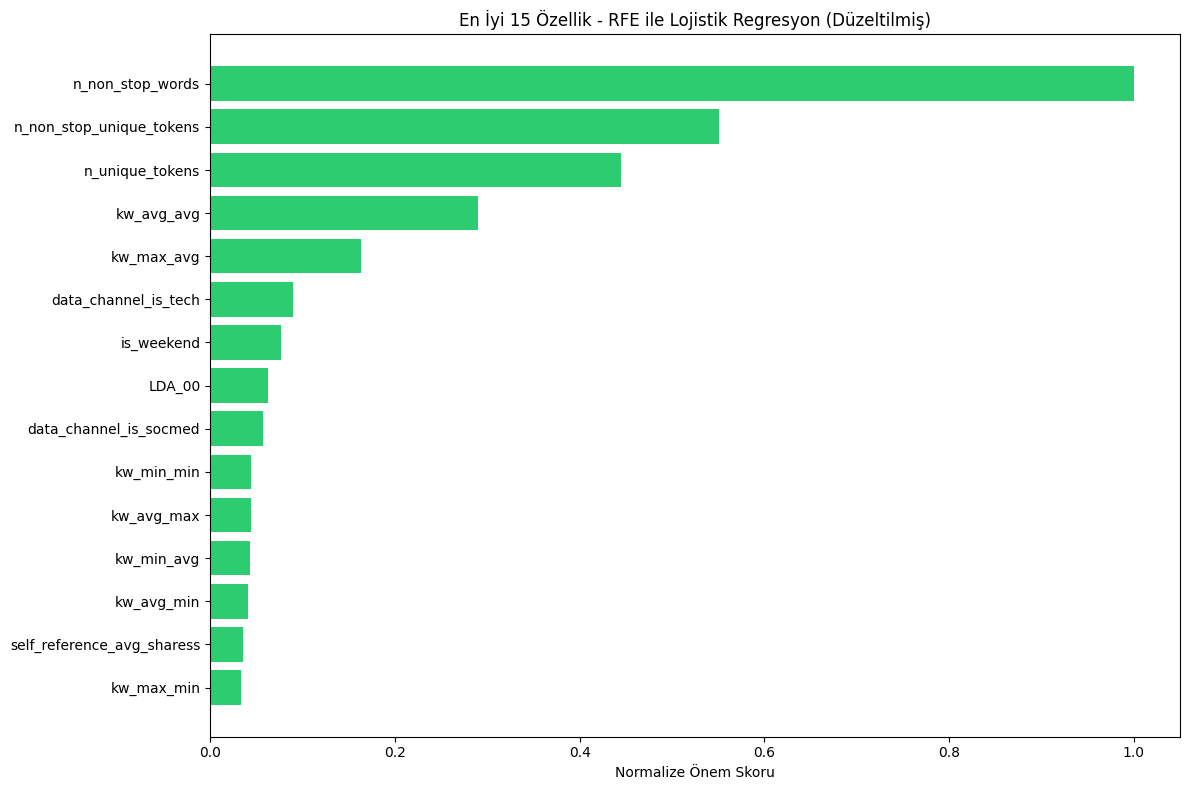

Grafik kaydedildi: wrapper_method_importance.png


In [10]:
import matplotlib.pyplot as plt

# Seçilen özellikler için bar plot
top_15_df = ranking_df.head(TOP_N).copy()

plt.figure(figsize=(12, 8))
colors = ['#2ecc71' if idx < 15 else '#3498db' for idx in range(len(top_15_df))]
plt.barh(range(len(top_15_df)), top_15_df['Normalize Skor'], color=colors)
plt.yticks(range(len(top_15_df)), top_15_df['Özellik'])
plt.xlabel('Normalize Önem Skoru')
plt.title('En İyi 15 Özellik - RFE ile Lojistik Regresyon (Düzeltilmiş)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('photos/wrapper_method_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("Grafik kaydedildi: wrapper_method_importance.png")

## 7. Analiz Raporu Oluştur

In [11]:
# Rapor için yöntem açıklaması
method_description = """
Sarmalayıcı yöntem olarak **Recursive Feature Elimination (RFE)** kullanılmıştır. 
Bu yöntem, **Lojistik Regresyon** algoritması ile birlikte uygulanmıştır.

### Yöntem Detayları:
- RFE, başlangıçta tüm özelliklerle başlar
- Her iterasyonda model eğitilir ve en az önemli özellik(ler) elenir
- Bu işlem istenilen özellik sayısına ulaşılana kadar devam eder
- Lojistik Regresyon katsayıları özellik önemini belirler

### Model Parametreleri:
- **Estimator:** LogisticRegression
- **Solver:** lbfgs
- **Max Iterations:** 1000
- **Step:** 1 (her adımda 1 özellik ele)

### Skorlama Yöntemi:
- Seçilen özellikler için **Lojistik Regresyon katsayılarının mutlak değerleri** kullanılmıştır
- Bu sayede özellikler arasında anlamlı bir önem sıralaması elde edilmiştir

### Avantajları:
- Model performansını doğrudan optimize eder
- Özellikler arası etkileşimleri dikkate alır
- Sıralı özellik seçimi sağlar

### Dezavantajları:
- Hesaplama maliyeti yüksek olabilir
- Seçilen modele bağımlı
"""

# Dataset bilgisi
dataset_info = {
    "name": "processed_dataset.csv",
    "shape": f"{df.shape}",
    "source": "UCI Online News Popularity"
}

# Ek notlar
additional_notes = """
RFE yöntemi, Lojistik Regresyon modelinin katsayılarını kullanarak özellik önemini belirler.
Bu nedenle, seçilen özellikler Lojistik Regresyon için en ayırt edici olanlardır.

**Not:** Veriler StandardScaler ile ölçeklendirilmiştir, bu Lojistik Regresyon için önemlidir.

**Düzeltme:** Bu rapor, Lojistik Regresyon katsayılarının mutlak değerleri kullanılarak oluşturulmuştur.
Önceki versiyonda tüm seçilen özellikler için RFE ranking=1 olduğundan normalize skorlar yanlışlıkla 1.0 çıkıyordu.
"""

# Rapor oluştur
report_content = generate_analysis_report(
    method_name="Sarmalayıcı Yöntem - RFE + Lojistik Regresyon",
    method_description=method_description,
    ranking_df=ranking_df,
    top_n=TOP_N,
    dataset_info=dataset_info,
    additional_notes=additional_notes
)

# Rapor kaydet
write_report(report_content, "wrapper_analysis_report.md")

print("\nRapor başarıyla oluşturuldu!")

Rapor kaydedildi: c:\Users\kayra\OneDrive\Üniversite\Dersler\Doktora\Dönem 1\Makine Öğrenmesi\ödev2\kodlar\feature_selection\wrapper_analysis_report.md

Rapor başarıyla oluşturuldu!


## 8. Seçilen Özelliklerle Veri Kümesi Oluştur

In [12]:
# Seçilen özelliklerle yeni veri kümesi oluştur ve kaydet
output_file = "wrapper_method_selected_dataset.csv"

save_selected_dataset(
    df=df,
    selected_features=selected_features,
    target_column='is_popular',
    filename=output_file
)

print(f"\n✅ Sarmalayıcı yöntemi tamamlandı!")
print(f"   - {TOP_N} özellik seçildi")
print(f"   - Veri kümesi: {output_file}")
print(f"   - Rapor: wrapper_analysis_report.md")


Seçilen özelliklerle veri kümesi kaydedildi: c:\Users\kayra\OneDrive\Üniversite\Dersler\Doktora\Dönem 1\Makine Öğrenmesi\ödev2\kodlar\feature_selection\..\dataset_files\wrapper_method_selected_dataset.csv
Boyut: (39644, 16)
Sütunlar: ['n_non_stop_words', 'n_non_stop_unique_tokens', 'n_unique_tokens', 'kw_avg_avg', 'kw_max_avg', 'data_channel_is_tech', 'is_weekend', 'LDA_00', 'data_channel_is_socmed', 'kw_min_min', 'kw_avg_max', 'kw_min_avg', 'kw_avg_min', 'self_reference_avg_sharess', 'kw_max_min', 'is_popular']

✅ Sarmalayıcı yöntemi tamamlandı!
   - 15 özellik seçildi
   - Veri kümesi: wrapper_method_selected_dataset.csv
   - Rapor: wrapper_analysis_report.md


## 9. Özet

In [13]:
print("="*60)
print("SARMALAYICI YÖNTEMİ - ÖZET (DÜZELTİLMİŞ)")
print("="*60)
print(f"Kullanılan Yöntem: RFE + Lojistik Regresyon")
print(f"Skorlama: Lojistik Regresyon Katsayıları (Mutlak Değer)")
print(f"Toplam Özellik Sayısı: {len(feature_names)}")
print(f"Seçilen Özellik Sayısı: {TOP_N}")
print(f"\nSeçilen Özellikler (Önem Sırasına Göre):")
for i, feat in enumerate(selected_features, 1):
    score = ranking_df[ranking_df['Özellik'] == feat]['Normalize Skor'].values[0]
    print(f"  {i:2d}. {feat:35} (Skor: {score:.4f})")
print("="*60)

SARMALAYICI YÖNTEMİ - ÖZET (DÜZELTİLMİŞ)
Kullanılan Yöntem: RFE + Lojistik Regresyon
Skorlama: Lojistik Regresyon Katsayıları (Mutlak Değer)
Toplam Özellik Sayısı: 58
Seçilen Özellik Sayısı: 15

Seçilen Özellikler (Önem Sırasına Göre):
   1. n_non_stop_words                    (Skor: 1.0000)
   2. n_non_stop_unique_tokens            (Skor: 0.5507)
   3. n_unique_tokens                     (Skor: 0.4451)
   4. kw_avg_avg                          (Skor: 0.2902)
   5. kw_max_avg                          (Skor: 0.1633)
   6. data_channel_is_tech                (Skor: 0.0900)
   7. is_weekend                          (Skor: 0.0771)
   8. LDA_00                              (Skor: 0.0625)
   9. data_channel_is_socmed              (Skor: 0.0576)
  10. kw_min_min                          (Skor: 0.0447)
  11. kw_avg_max                          (Skor: 0.0438)
  12. kw_min_avg                          (Skor: 0.0428)
  13. kw_avg_min                          (Skor: 0.0415)
  14. self_reference_av